In [4]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from nnsight import LanguageModel
import matplotlib.pyplot as plt
import pandas as pd
import os
from huggingface_hub import login
import pickle
from scipy.fft import fft, fftfreq
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import json
import itertools
from matplotlib.patches import Wedge
COL_WIDTH = 3.25
TWO_COL_WIDTH = 6.75

In [5]:
OPERATION = 'addition'
assert OPERATION in ['addition', 'multiplication']



In [6]:
# Load model# Set the token as an environment variable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
full_model_name = 'EleutherAI/gpt-j-6B'
# full_model_name = 'EleutherAI/pythia-6.9b'
#full_model_name = 'google/gemma-2-9b'#'##
MODEL_NAME = full_model_name.split('/')[-1]
remote = False
datapath = f'llm-addition/experimentation'


In [7]:
model = LanguageModel(full_model_name, device_map=device, torch_dtype=torch.bfloat16, dispatch=True)
NLAYERS = model.config.num_hidden_layers



Some weights of the model checkpoint at EleutherAI/gpt-j-6B were not used when initializing GPTJForCausalLM: ['transformer.h.0.attn.bias', 'transformer.h.0.attn.masked_bias', 'transformer.h.1.attn.bias', 'transformer.h.1.attn.masked_bias', 'transformer.h.10.attn.bias', 'transformer.h.10.attn.masked_bias', 'transformer.h.11.attn.bias', 'transformer.h.11.attn.masked_bias', 'transformer.h.12.attn.bias', 'transformer.h.12.attn.masked_bias', 'transformer.h.13.attn.bias', 'transformer.h.13.attn.masked_bias', 'transformer.h.14.attn.bias', 'transformer.h.14.attn.masked_bias', 'transformer.h.15.attn.bias', 'transformer.h.15.attn.masked_bias', 'transformer.h.16.attn.bias', 'transformer.h.16.attn.masked_bias', 'transformer.h.17.attn.bias', 'transformer.h.17.attn.masked_bias', 'transformer.h.18.attn.bias', 'transformer.h.18.attn.masked_bias', 'transformer.h.19.attn.bias', 'transformer.h.19.attn.masked_bias', 'transformer.h.2.attn.bias', 'transformer.h.2.attn.masked_bias', 'transformer.h.20.attn.bi

In [8]:
device

device(type='cuda')

In [9]:
def get_nums_hss(target, mina = 0,maxa = 99, sample = True):
    suffix = '_FULL' if not sample else ''
    save_path = f'{datapath}/data_{OPERATION}/helix_hss/{target}_helix_data_{mina}_{maxa}{suffix}_{MODEL_NAME}.pt'
    obj = torch.load(save_path, weights_only=True)
    a,b,a_b, hss = obj['a'], obj['b'], obj['a+b'], obj['hidden_states']
    return a,b,a_b, hss

def get_nums_hss_solo(mina = 0,maxa = 99):
    nums = np.linspace(mina, maxa, maxa-mina+1)
    tokens = torch.tensor(model.tokenizer([f'{int(num)}' for num in nums])['input_ids'])
    activations = []
    with torch.no_grad():
        with model.trace(validate=False,remote=remote) as tracer:
            with tracer.invoke(tokens, scan=False):
                for layer in range(NLAYERS):
                    if MODEL_NAME == 'Llama-3.1-8B':
                        hs = model.model.layers[layer].input
                    elif MODEL_NAME == 'gpt-j-6B':
                        hs = model.transformer.h[layer].inputs[1]['hidden_states']
                    elif MODEL_NAME == 'pythia-6.9b':
                        hs = model.gpt_neox.layers[layer].input
                    activations.append(hs[:,-1].save())
    act = torch.stack(activations).detach().cpu()
    act = act.transpose(0, 1)
    return nums, act


In [18]:
mina = 1
maxa = 99
layer = 3
a, hss = get_nums_hss_solo( mina, maxa)
# Filter out zeros, they cannot be used with log
mask = (a != 0)
hss = hss[mask]
a = a[mask]

In [11]:
#Attempt linear fit vs full hidden state

# from sklearn.linear_model import LinearRegression
# model = LinearRegression()
# model.fit(hss[:,layer,:].cpu().float().numpy(), a.cpu().float().numpy())
# print("coef", model.coef_)
# print("intercept", model.intercept_)
# print("r2 score", model.score(hss[:,layer,:].cpu().float().numpy(), a.cpu().float().numpy()))
# print("predicted", model.predict(hss[:,layer,:].cpu().float().numpy()))
# from sklearn.metrics import r2_score
# y_true = a.cpu().float().numpy()
# y_pred = model.predict(hss[:,layer,:].cpu().float().numpy())
# r2 = r2_score(y_true, y_pred)
# print("R2 score of the model: ", r2)

# Right... this is useless as with 4096 dim hiddeen state, you can regress anything perfectly. Hence PCA. Let's try that...


In [19]:
# PCA decompose and attempt fit against each of them

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

npca = 20


hs = hss[:, layer, :].cpu().float().numpy()
scaler = StandardScaler()
hs_scaled = scaler.fit_transform(hs)

pca = PCA(n_components=npca)
tf = pca.fit_transform(hs_scaled)
# print("explained_variance_ratio", pca.explained_variance_ratio_)
# print("explained_variance", pca.explained_variance_)
# print("singular_values", pca.singular_values_)
# print("components", pca.components_)
for i in range(npca):
    lr = LinearRegression()
    x = np.log(a)[:, None]
    y = tf[:,i]
    lr.fit(x, y)
    # print("coef", i, model.coef_)
    # print("intercept", i, model.intercept_)
    print("r2 score", i, lr.score(x, y))
    # print("predicted", i, model.predict(x))



r2 score 0 0.004086465146207585
r2 score 1 0.7890131284956708
r2 score 2 0.09640290882862401
r2 score 3 0.03907299596194358
r2 score 4 0.0026311593960429702
r2 score 5 0.022133971220210658
r2 score 6 0.007130549224976246
r2 score 7 7.476088507596401e-06
r2 score 8 0.00021801002095833688
r2 score 9 0.010812806204597125
r2 score 10 0.00056415874229232
r2 score 11 0.0019396223803295198
r2 score 12 0.0006411400720427451
r2 score 13 0.00026445682343434473
r2 score 14 0.002373675052398494
r2 score 15 0.0004622099957201087
r2 score 16 0.0001434699220574931
r2 score 17 0.0027688994771940534
r2 score 18 0.0022163028404271756
r2 score 19 0.002623649465567812


In [20]:
pca.explained_variance_ratio_

array([0.56916666, 0.0497121 , 0.03213201, 0.02692502, 0.02198323,
       0.0181959 , 0.01535888, 0.01390128, 0.01240479, 0.01115358,
       0.01022297, 0.00977414, 0.00923395, 0.00907297, 0.0078138 ,
       0.0074817 , 0.00727391, 0.00686399, 0.00660673, 0.00654443],
      dtype=float32)

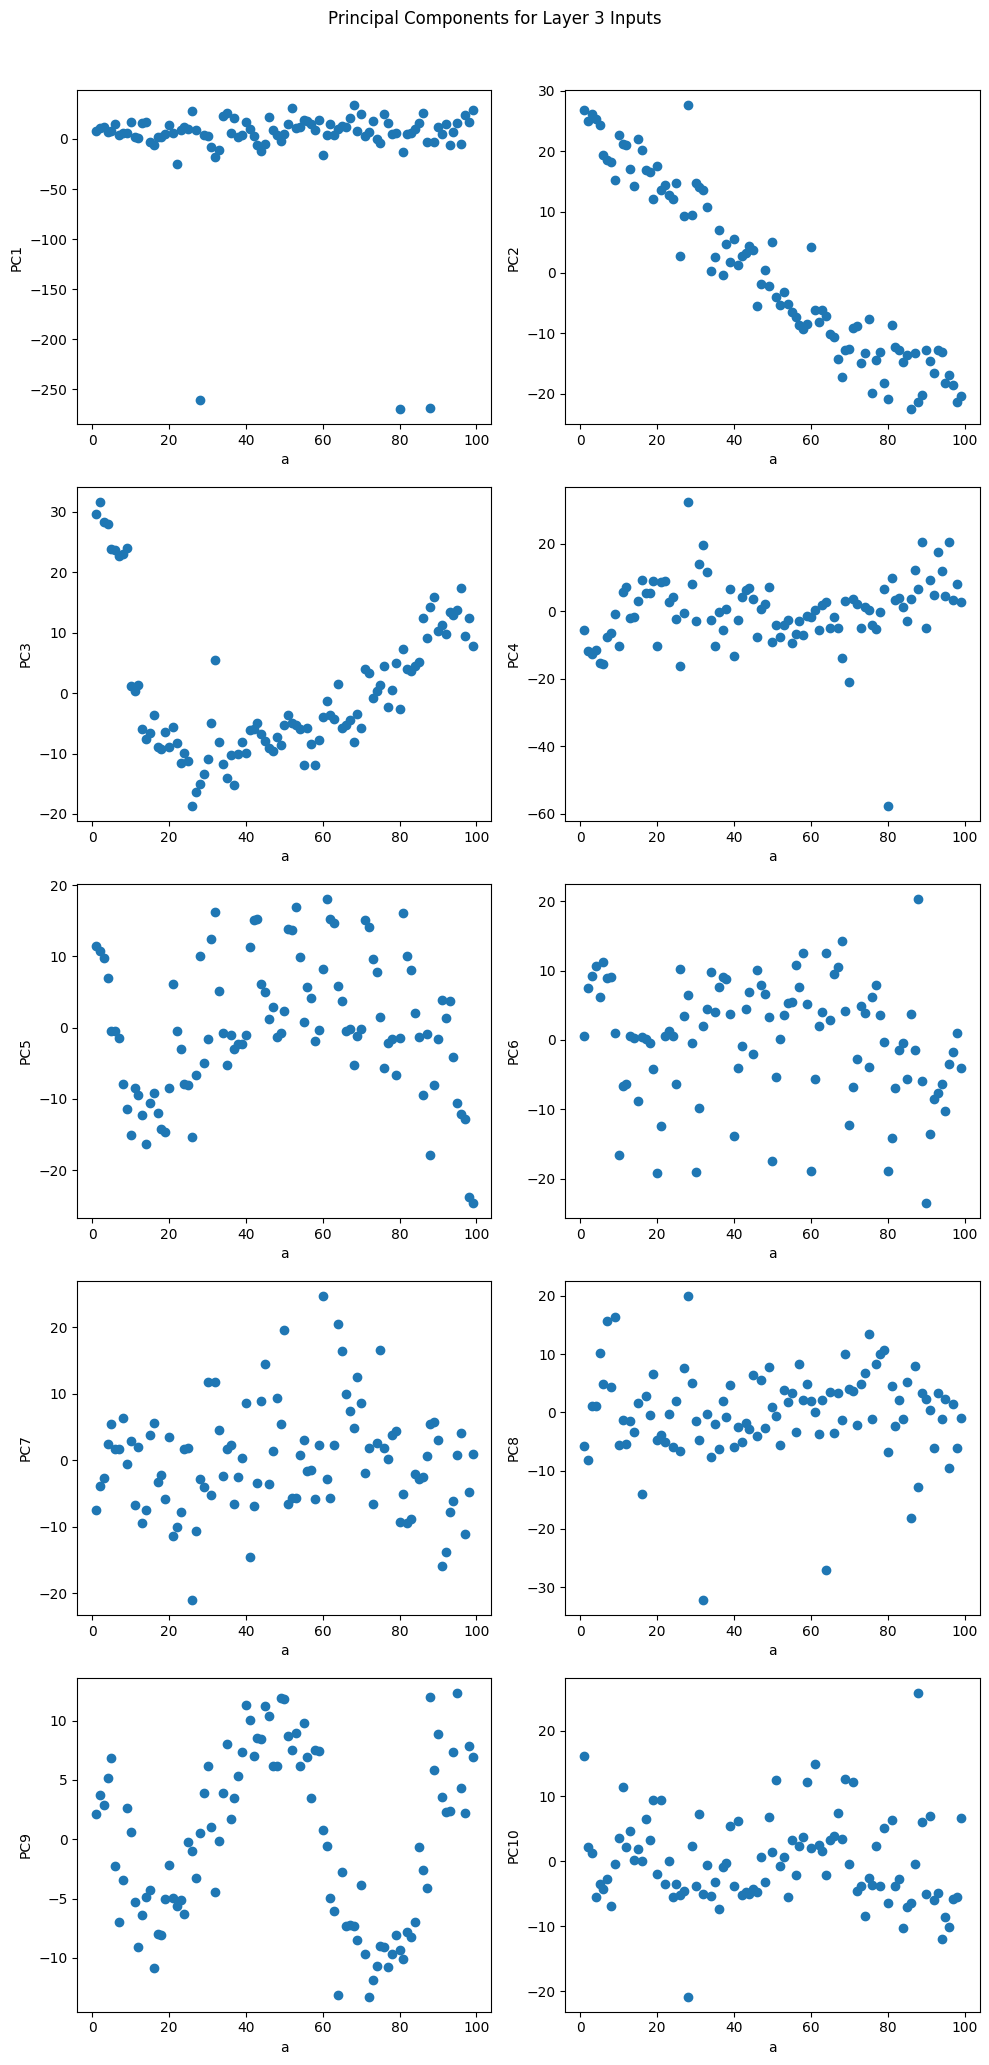

In [21]:
# Plot principal components

import matplotlib.pyplot as plt
#rng = slice(0, 105)
rng = slice(None, None)
fig, axs = plt.subplots(5, 2, figsize=(10, 20))
axs = axs.ravel()
for i in range(10):
    x = a[rng]
    # x = np.log(a[rng] / 50)
    axs[i].scatter(x, (tf[:, i][rng]))
    axs[i].set_xlabel('a')
    axs[i].set_ylabel(f'PC{i+1}')
plt.tight_layout()
fig.suptitle(f'Principal Components for Layer {layer} Inputs', y=1.03)
plt.show()

100%|██████████| 1/1 [00:00<00:00, 489.70it/s]

linear r2 score 0.0044104153262258805 0
log r2 score 0.00462826079701939 0
log is better


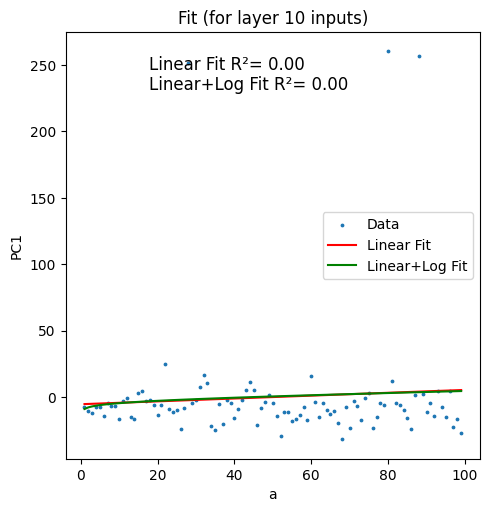

100%|██████████| 1/1 [00:00<00:00, 507.23it/s]


linear r2 score 0.7941655253639449 0
log r2 score 0.8029085381915833 0
log is better


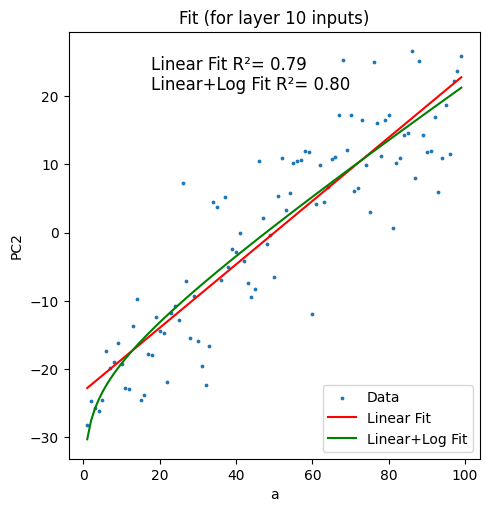

100%|██████████| 1/1 [00:00<00:00, 663.24it/s]


linear r2 score 0.14126188589421296 0
log r2 score 0.27962407259638766 0
log is better


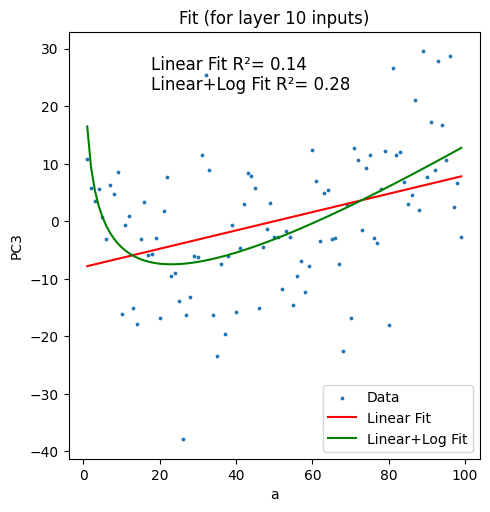

100%|██████████| 1/1 [00:00<00:00, 503.10it/s]

linear r2 score 0.008931259707006034 0
log r2 score 0.6593814526974429 0
log is better


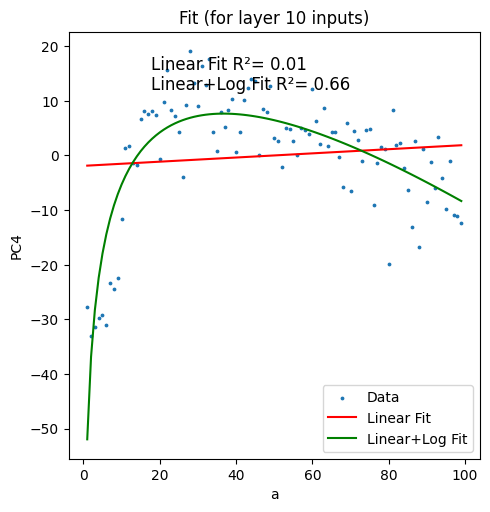

100%|██████████| 1/1 [00:00<00:00, 287.10it/s]


linear r2 score 0.0004214798831585487 0
log r2 score 0.0032210135567215525 0
log is better


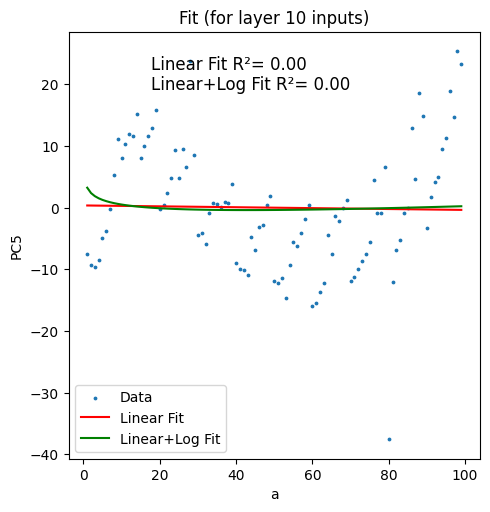

In [14]:
# Fits a given component to a linear/log fit.

import matplotlib.pyplot as plt
#rng = slice(0, 105)
rng = slice(None, None)

component = 6
for component in range(0, 5):
    y = tf[:, component]

    def fit(period, is_log):
        if is_log:
            t = [a, np.log(a)]
        else:
            t = [a]

        X = np.stack(t, axis = 1)

        lr = LinearRegression()
        
        lr.fit(X, y)
        r2 = lr.score(X, y)

        y_pred = lr.predict(X)

        return r2, lr, y_pred, period

    def best_fit(periods, is_log):
        results = [fit(period, is_log) for period in tqdm(periods)]
        best = max(results, key=lambda x: x[0])
        return best

    best_linear = best_fit([0], False)
    best_log = best_fit([0], True)

    fig, axs = plt.subplots(1, 1, figsize=(5, 5))
    axs = axs

    axs.scatter(a, y, s=3)
    axs.plot(a, best_linear[2], color='red')
    axs.plot(a, best_log[2], color='green')
    axs.set_xlabel('a')
    axs.set_ylabel(f'PC{component+1}')
    plt.tight_layout()
    print("linear r2 score", best_linear[0], best_linear[3])
    print("log r2 score", best_log[0], best_log[3])
    print("log is better" if best_log[0] > best_linear[0] else "linear is better")
    plt.legend(['Data', 'Linear Fit', 'Linear+Log Fit'])
    plt.text(0.2, 0.9, f'Linear Fit R²= {best_linear[0]:.2f}\nLinear+Log Fit R²= {best_log[0]:.2f}', horizontalalignment='left', verticalalignment='center', transform=axs.transAxes, fontsize=12)
    plt.title(f'Fit (for layer {layer} inputs)')
    plt.show()

# LOG is better: PC3




  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [00:00<00:00, 832.95it/s]


linear r2 score 0.06041347916582407 53.727935718009924
log r2 score 0.06603041617588756 1.1235166816909297
log is better


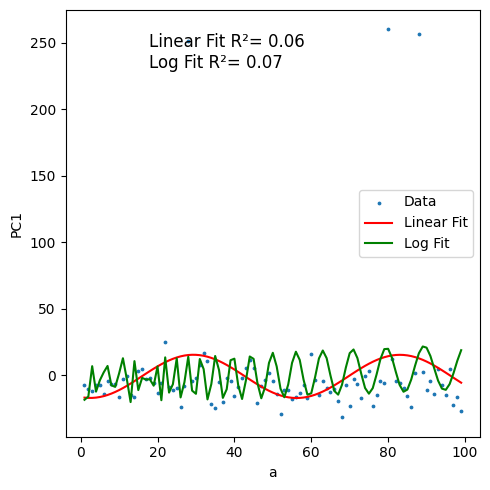

100%|██████████| 300/300 [00:00<00:00, 859.15it/s]


linear r2 score 0.8161238478607051 94.37051691458994
log r2 score 0.8299748570715254 1.4153714151170234
log is better


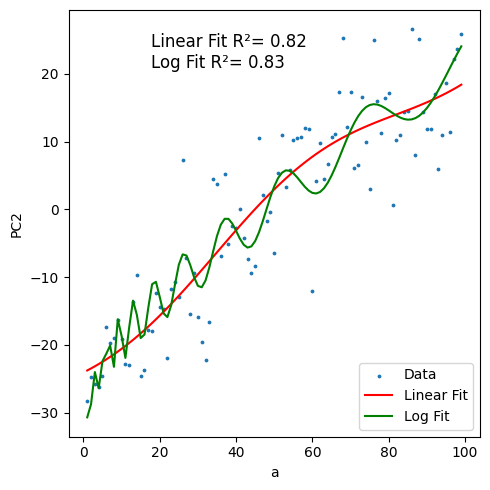

100%|██████████| 300/300 [00:00<00:00, 838.23it/s]


linear r2 score 0.2825863996392034 300.0000000000001
log r2 score 0.3909104765875989 1.4045182622619168
log is better


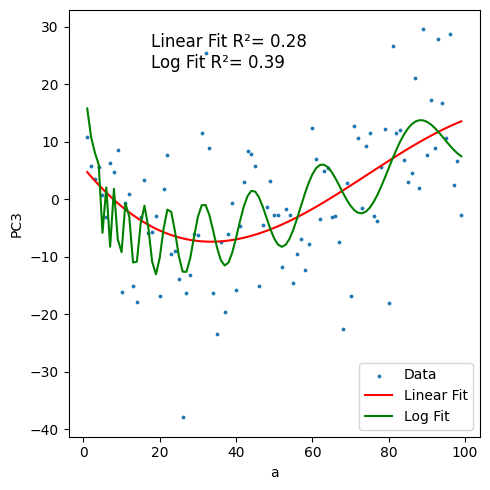

100%|██████████| 300/300 [00:00<00:00, 822.83it/s]


linear r2 score 0.6866185086663272 300.0000000000001
log r2 score 0.6993914101444172 10.0
log is better


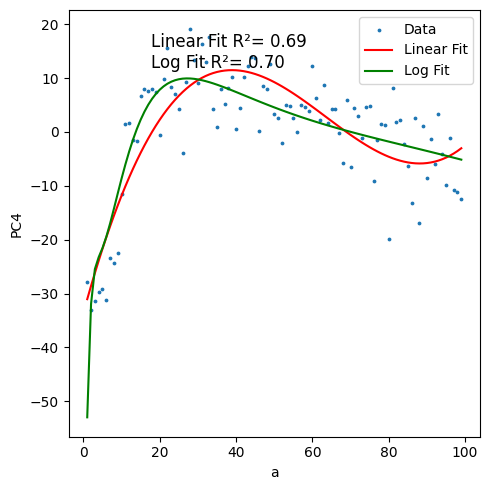

100%|██████████| 300/300 [00:00<00:00, 821.54it/s]


linear r2 score 0.5058376094255188 157.99829944285997
log r2 score 0.39775340791777225 10.0
linear is better


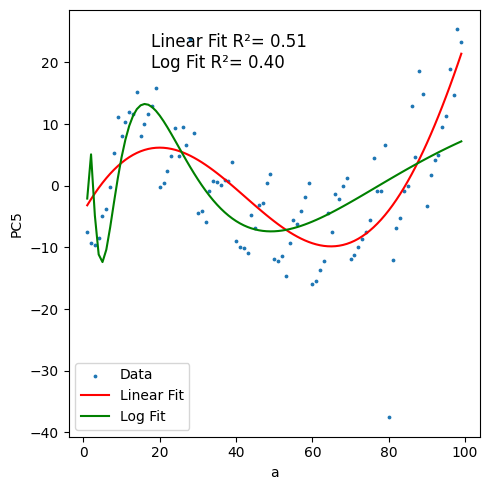

100%|██████████| 300/300 [00:00<00:00, 831.34it/s]


linear r2 score 0.11229308968268992 66.26559377945091
log r2 score 0.21127421092726617 10.0
log is better


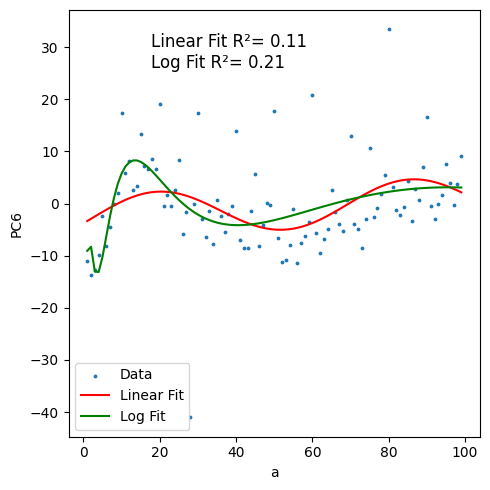

100%|██████████| 300/300 [00:00<00:00, 807.72it/s]


linear r2 score 0.1416898906568752 84.7210067936504
log r2 score 0.1764887666031364 1.1497637569508672
log is better


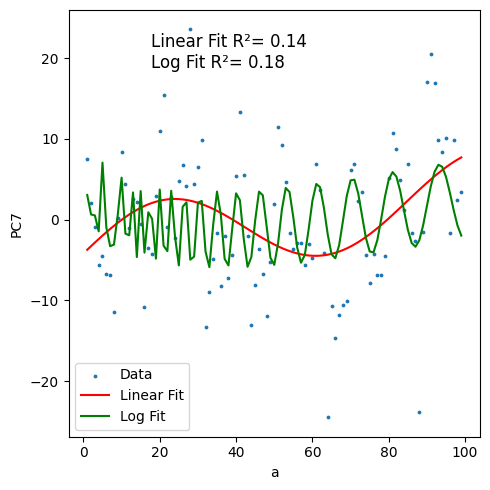

100%|██████████| 300/300 [00:00<00:00, 847.47it/s]


linear r2 score 0.13947567404158268 60.569000311835126
log r2 score 0.13445123500352185 1.4153714151170234
linear is better


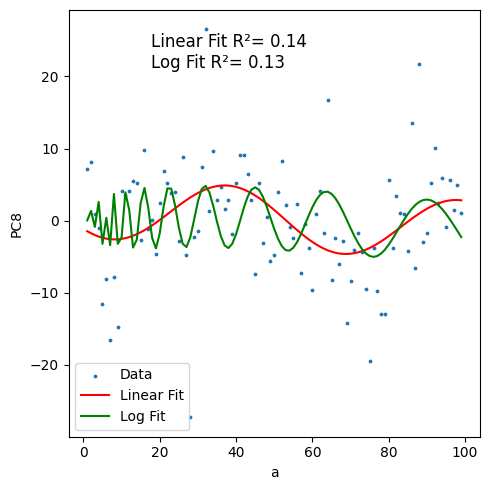

100%|██████████| 300/300 [00:00<00:00, 838.49it/s]


linear r2 score 0.24966160908829838 60.2071255299767
log r2 score 0.17315747412015936 7.697274690794687
linear is better


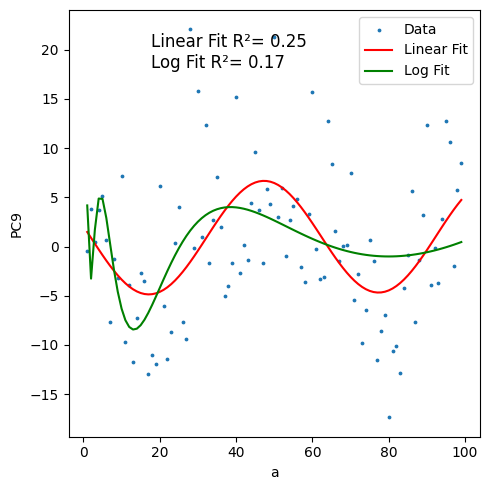

100%|██████████| 300/300 [00:00<00:00, 838.16it/s]


linear r2 score 0.48852760933816364 52.77067109539629
log r2 score 0.3350506832573211 2.388891634026276
linear is better


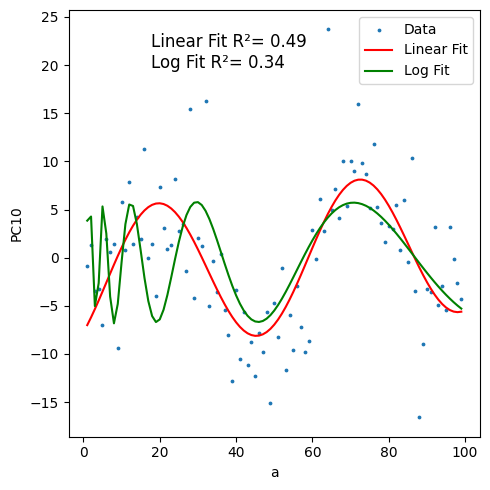

In [15]:
# Fits a given sin/cos component to a sine wave.

import matplotlib.pyplot as plt
#rng = slice(0, 105)
rng = slice(None, None)

component = 6
for component in range(0, 10):
    y = tf[:, component]

    def fit(period, is_log):
        if is_log:
            t = np.log(a)
            sina = np.sin(t / np.log(period) * 2*np.pi)
            cosa = np.cos(t / np.log(period) * 2*np.pi)
        else:
            t = a/period
            sina = np.sin(t * 2*np.pi)
            cosa = np.cos(t * 2*np.pi)

        X = np.stack([a, t, sina, cosa], axis = 1)

        lr = LinearRegression()
        
        lr.fit(X, y)
        r2 = lr.score(X, y)

        y_pred = lr.predict(X)

        return r2, lr, y_pred, period

    def best_fit(periods, is_log):
        results = [fit(period, is_log) for period in tqdm(periods)]
        best = max(results, key=lambda x: x[0])
        return best

    best_linear = best_fit(np.logspace(np.log10(50), np.log10(300), 300), False)
    best_log = best_fit(np.logspace(np.log10(1.001), np.log10(10), 300), True)

    fig, axs = plt.subplots(1, 1, figsize=(5, 5))
    axs = axs

    axs.scatter(a, y, s=3)
    axs.plot(a, best_linear[2], color='red')
    axs.plot(a, best_log[2], color='green')
    axs.set_xlabel('a')
    axs.set_ylabel(f'PC{component+1}')
    plt.tight_layout()
    print("linear r2 score", best_linear[0], best_linear[3])
    print("log r2 score", best_log[0], best_log[3])
    print("log is better" if best_log[0] > best_linear[0] else "linear is better")
    plt.legend(['Data', 'Linear Fit', 'Log Fit'])
    plt.text(0.2, 0.9, f'Linear Fit R²= {best_linear[0]:.2f}\nLog Fit R²= {best_log[0]:.2f}', horizontalalignment='left', verticalalignment='center', transform=axs.transAxes, fontsize=12)

    plt.show()

# LOG is better: PC3




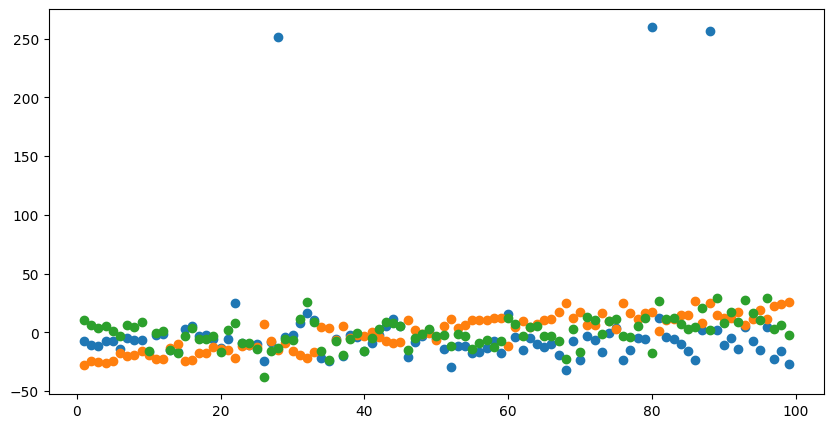

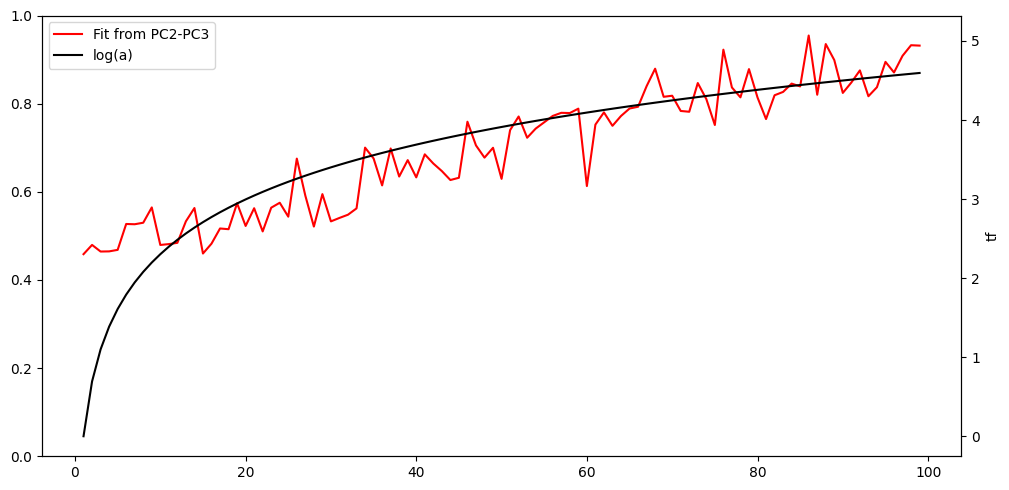

r2 score of lr: 0.7350737157403062
coefficients of lr: [0.05198025 0.01307908]


In [16]:
# Fit PC to logarithm.
# I played with components and alpha and it never plausibly recovered a fit.
components = slice(0, 10)
from sklearn.linear_model import Lasso
lr = Lasso(alpha=3)

components = slice(1, 3)
lr = LinearRegression()

lr.fit(tf[:, components], np.log(a))
plt.figure(figsize=(10, 5))
plt.scatter(a, tf[:, 0], label='PC1')
plt.scatter(a, tf[:, 1], label='PC2')
plt.scatter(a, tf[:, 2], label='PC3')
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()
# ax1.scatter(a, tf[:, 0], label='PC1')
# ax1.scatter(a, tf[:, 1], label='PC2')
ax2.plot(a, lr.predict(tf[:, components]), color='red', label=f'Fit from PC{components.start+1}-PC{components.stop}')
ax2.plot(a, np.log(a), color='black', label='log(a)')
plt.tight_layout()
plt.xlabel('a')
plt.ylabel('tf')
plt.legend()
plt.show()
print("r2 score of lr:", lr.score(tf[:, components], np.log(a)))
print("coefficients of lr:", lr.coef_)



In [17]:
def check_tokenization(mina, maxa):
    "Check range of values is safe for the one-token assumption. More precise than the original paper."
    for a in range(mina, maxa+1):
        for b in range(mina, maxa+1):
            if OPERATION == "addition":
                text = f"{a}+{b}="
            else:
                text = f"{a}*{b}="
            tokens = model.tokenizer.tokenize(text)
            assert len(tokens) == 4, tokens
check_tokenization(0, 520)